# Main effects

In [1]:
library(tidyverse)

gwas <- read_tsv('~/projects/waffles/results/main_effects/plink.assoc.logistic', col_types = 'icdccdddd') %>%
    filter(TEST == 'ADD') %>%
    rename(chr = CHR, snp = SNP, pos = BP) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
gene2symbol <- read_tsv('~/projects/waffles/results/fuma_mapping/genes.tsv', col_types = 'ccicc') %>%
    select(ensg, symbol)
n_selected <- filter(gwas, selected == 'Yes') %>% nrow

get_n <- function(file, col_types) {
    
    snp2gene <- read_tsv(paste0('~/projects/waffles/results/fuma_mapping/', file), col_types = col_types) %>%
        select(rsID, ensg) %>%
        unique
    
    total <- group_by(snp2gene, ensg) %>%
        summarize(n_snps = n()) %>%
        arrange(-n_snps) %>%
        mutate(rank = 1:n())
    
    genes <- inner_join(gwas, snp2gene, by = c('snp' = 'rsID')) %>%
        filter(selected == 'Yes') %>%
        group_by(ensg) %>%
        summarize(hits = n())
    
    full_join(total, genes, by = 'ensg') %>%
        mutate(hits = ifelse(is.na(hits), 0, hits)) %>%
        left_join(gene2symbol, by = "ensg")
    
}

Warning message:
“Removed 52956 rows containing missing values (geom_point).”Warning message:
“Removed 52956 rows containing missing values (geom_point).”

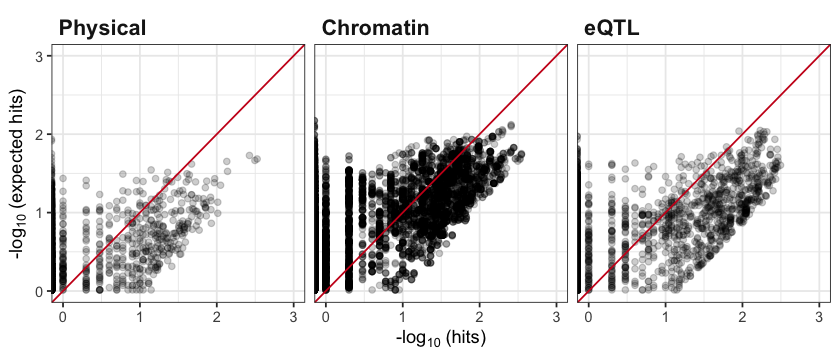

In [3]:
options(repr.plot.width=7, repr.plot.height=3)
bind_rows(get_n('physical_mapping.tsv', 'cccc') %>% mutate(mapping = 'Physical'),
          get_n('eqtl_mapping.tsv', 'ccc') %>% mutate(mapping = 'eQTL'),
          get_n('chromatin_interaction_mapping.tsv', 'cccc') %>% mutate(mapping = 'Chromatin')) %>%
    mutate(mapping = factor(mapping, levels = c('Physical', 'Chromatin', 'eQTL'))) %>%
    ggplot(aes(log10(hits), log10((n_selected * n_snps)/nrow(gwas)))) +
        geom_point(alpha=0.2) +
        geom_abline(slope = 1, color = '#cb181d') +
        facet_grid(~mapping) +
        scale_x_continuous(limits = c(0, 3)) +
        scale_y_continuous(limits = c(0, 3)) +
        labs(x = bquote('-log' [10]~'(hits)'),
             y = bquote('-log' [10]~'(expected hits)')) +
        theme_bw() +
        theme(strip.background = element_blank(),
              strip.text = element_text(size = 13, face = "bold", hjust=0))
ggsave('fig/main_effect_bias.png', width=7, height=3)